In [8]:
###Project Orwell Main file
##Synopsis
'''
Script containing the core mechanics for the project, including the representation of people, objects and structures as 
distinct classes which use data structures and methods to simulate elements of life. With location and velocity being 
updated by physical accelerations provided by the environment, and things like emotions and ideologies being updated by
mental accelerations provided by the environment.
'''
##
##Imports
import numpy as np
import matplotlib.pyplot as plt
import random
##
##Function and Class definitions
#defining a custom normalization function, if a more efficient solution is found, then it can simply be inserted here, no upset
def norm(vector):
    return vector/np.linalg.norm(vector)
#

class Entity:
    '''
    defining the principle class of the objects simulated in the program, these are currently synonymous with the 'people'
    '''
    def __init__(self,name,z,y,x,velz,vely,velx,forces,maxcv=0.5):
        '''
        grav, inter, pos and vel are lists. pos and vel are 3vectors, args are expected to be a set of tuples of the gravitas' 
        and interaction strength's of the object on the set of potentials paired with a dictionary of the potentials names.
        calling the x,y,z components of the entity's position will return the integer values of the co-ordinates of the object 
        on the raster map.
        want to create a 2 dimensional array, with the vector of the position as one dimension and then the time of occurance 
        as another.
        the fatigue represents the object's tiredness with moving at it current pace. it will grow whenever it is moving above
        the max comfortable pace and decay whenever it is below. 
        '''
        self.x = x
        self.y = y
        self.z = z
        self.name = name
        self.vel = np.array([velz,vely,velx],dtype='float64')
        self.pos = np.array([z,y,x],dtype='float64')
        self.rpos=self.pos.astype(int)
        self.forces = forces
        self.trajectory = self.pos
        self.fatigue = 0
        self.maxcv = maxcv
    def getForces(self,potname):
        '''Function which gets the forces tuple for the specified potential if it exists'''
        try:
            return self.forces[potname]
        except KeyError:
            return 0,0
    def update(self,pot,timestep):
        '''looks to find the potential at the six points on the field adjacent to the objects position
        initially tries to find the direction vector of the force experienced by the object. Uses a set of tuples as the 
        field indexes and wraps them according to the shape of the field
        once successful it then stacks the new position onto the trajectory matrix, extending it and thus recording the 
        positition at that time interval.
        '''
        


        self.pos += timestep * self.vel
        self.pos %= 363
        self.rpos=self.pos.astype(int)
        self.fatigueupdate()
        self.vel *= 1-self.fatigue
        self.vel += timestep * (self.getAcc(pot) + self.getQuestAcc())
        self.z,self.y,self.x = self.rpos[0],self.rpos[1],self.rpos[2]
        self.trajectory = np.vstack([self.trajectory, self.pos])
        self.checkQuest()
    def fatigueupdate(self):
        self.fatigue += (np.linalg.norm(self.vel)/self.maxcv) -1
        if self.fatigue > 1:
            self.fatigue = 1
        elif self.fatigue <0:
            self.fatigue = 0
    def getAcc(self,pot):
        try:
            r_=np.array([pot.field[tuple((self.rpos)%pot.field.shape[0])]-pot.field[tuple((self.rpos)%pot.field.shape[0])],pot.field[tuple((self.rpos+(0,1,0))%pot.field.shape[1])]-pot.field[tuple((self.rpos+(0,-1,0))%pot.field.shape[1])],pot.field[tuple((self.rpos+(0,0,1))%pot.field.shape[2])]-pot.field[tuple((self.rpos+(0,0,-1))%pot.field.shape[2])]])
        except IndexError:
            r_=np.zeros(3)
            print('indexerror')
        return self.getForces(pot.name)[1]*-1*r_ 
    def getQuestAcc(self):
        try:
            dir_quest = self.objective-self.pos
            acc_quest = self. deter * dir_quest/np.linalg.norm(dir_quest)
            return acc_quest
        except AttributeError:
            return np.zeros(3)
    def setQuest(self,objective,deter):
        '''Function which introduces a directive to the object'''
        self.objective = objective # the location of the objective
        self.deter = deter # the drive/determination of the entity to get to the objective
    def checkQuest(self):
        try:
            if np.linalg.norm(self.objective-self.pos) < 0.5:
                delattr(self,'objective')
            else:
                pass
        except AttributeError:
            pass
        except NameError:
            pass
        
class Potential:
    '''this defines the class of potentials, this was used to both conform with the general style of oop for the rest of the project 
    and so that the unique evaluation method can be defined '''
    def __init__(self,name,dimz,dimy,dimx,width):
        '''
        defines the potential's name, initial dimensions, and the width parameter describing its range.
        '''
        self.name = name
        self.field = np.zeros((dimz,dimy,dimx))
        self.width = width
    def rangetest(self,entity,sensitivity):
        '''
        cannot permit zero in the cases where a field has no range, and cannot be less than zero as it would be 
        if it wouldnt be detected at the specified level at any range.
        '''
        gravitas = np.abs(entity.getForces(self.name)[0])
        if gravitas != 0:
            maxrangesquared = 2*(self.width**2)*(np.log(gravitas)-np.log(sensitivity))
        else:
            maxrangesquared = 0.0
        if maxrangesquared > 0:
            maxrange= np.sqrt(maxrangesquared)
        else:    
            maxrange = 0
        return maxrange
    def update(self,i,ran):
        '''i is an list of object, which is generating a field of that potential type
        First gets the raw, floating value of the range limitation from the rangetest method
        then rounds the value to the nearest integer and uses that as the criteria to create the cube of acceptable values
        then finds the magnitude of the difference vector between the raised co-ordinates and the co-ordinates of the entity 
        in question
        then implements the further limits on the cube of acceptable values to create the sphere of acceptable values
        then for each value in that sphere it calls up the value at those co-ords and updates it withthe new calculation                
        '''        
        self.field = np.zeros(np.shape(self.field))
        for j in i:
            r_raw=self.rangetest(j,ran)
            r = int(round(r_raw))
            for z in range(0,1):
                for y in range(j.y - r,j.y + r+1):#include the z range variance once working with 3d variables            
                    for x in range(j.x - r,j.x + r+1):
                        rp_mag = np.linalg.norm(np.array([x-j.x,y-j.y,z-j.z]))
                        if rp_mag<r_raw:
                            try:
                                self.field[z,y,x] -= j.getForces(self.name)[0]*np.exp(-1*pow(rp_mag,2)/(2*pow(self.width,2)))
                            except IndexError:
                                continue
                        else:
                            continue
##


ModuleNotFoundError: No module named 'matplotlib'

In [3]:
##Defining the instances of the potentials and objects

pots=[Potential('Grav',1,363,363,4),Potential('Radpres',1,363,363,3)]#formatting of z,y,x
objs = []
'''Simulating entities with outward pressure'''
for j in range(0):
    objs.append(Entity('Mount{}'.format(j),
                       0,random.randint(0,363),random.randint(0,363),
                       0,0,0,
                       {'Grav':(0,0),'Radpres':(-random.random(),0)}))
'''Simulating entities gravitating towards one another'''    
for i in range(100):
    objs.append(Entity('Person{}'.format(i),
                       0,random.randint(0,363),random.randint(0,363),
                       0,random.random()-1,random.random()-1,
                       {'Grav':(random.random(),random.random())}))

##

In [2]:
## Get function
def get(St, func):
    try:
        Va = func(input(St))
        return Va
    except ValueError:
        return get(St,func) 

In [9]:
## Defining the objects with user input

def create_object(potential_list):
    name = get("Name Your Entity: ", str)
    dynamics = [0,0,0,0,0,0]
    attributes = ['z','y','x','zvel','yvel','xvel']
    for j in range(len(attributes)):
        dynamics[j] = get(attributes[j],float)
    # elements to add in the force attributes
    
        
            
        

In [4]:
##Running the sim
steps=100
for t in range(steps):
    for p in pots:
        p.update(objs,0.01)
        for i in objs:
            i.update(p,0.1)
##


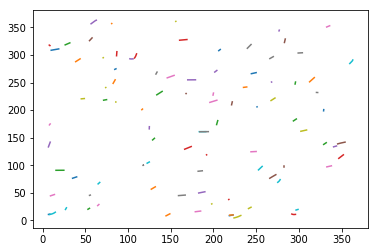

In [5]:
##Trajectory plotting on static map
for i in range(len(objs)):
    test = objs[i].trajectory.T
    plt.plot(test[1],test[2])
plt.show()
##

In [ ]:
objs[0].objective

In [ ]:
delattr(objs[0],'objective')


In [ ]:
objs[0].setQuest(np.array([0,8,12]),1)

In [ ]:
#Test cases to determine the method of fatigue update
'''
xval = np.linspace(1,200,1000)
maxcv = 50
mediator = 0.1
def f1(xval,maxcv):
    rawout = xval - maxcv
    return mediator * rawout
def f2(xval,maxcv):
    rawout = (xval/maxcv)-1
    return mediator *rawout
def f3(xval,maxcv):
    rawout = ((xval-maxcv)/xval)
    return mediator *rawout
#plt.plot(xval,f1(xval,maxcv),label='Function 1')
plt.plot(xval,f2(xval,maxcv),label='Function 2')
plt.plot(xval,f3(xval,maxcv),label='Function 3')
plt.legend(loc=0)
plt.show()
'''


In [ ]:
'''
class Structure(Entity):
    def __init__(self):# the subcalss initialisation is broken, replace
        super(Structure, self).__init__()
    def update(self,pot,timestep):
        pass
'''

In [ ]:
#objs[1].direct(np.array([0,15,15]),2)

In [ ]:
'''        self.objective = np.array([0,0,0])
        self.deter = 02

        
        if self.deter !=0:
            self.vel = (self.objective-self.pos)*self.deter#This causes a velocity towards the objective with a direction which varies with the position but a constant velocity determined by the determination
            self.deter *=0.9
        else:
            pass
'''

In [ ]:
'''
Theorise that a redesign using a system of updateing only the areas of the potential which will be affected noticably, and have the update type be applying a calculated difference.
'''

'''
suggested effciency move to not run the update code where the change would be minimal. calculate the range at which the gaussian topography becaomes effectively zero and just ignore those co-ordinates when updating. 
the magnitude of the change depends on the magnitude of the vecotr of differences in position. a constraint on that vector defines a sphere of non-sero affectation. 

the radius wil be defined by the object's gravitas and the range of the force. in the form of gravitas x exponential of 1/ twice the square of the range. this will be a positive value, which will be exponentially damped by the negative exponent of the magnitude of the difference in position. there will be a criteria where a given radius is sufficient to damp the function almost entirely to zero.

calculated for this test as the force power of 1/2 which comes from both the range and the gravitas parameters being defined as 1 for the test. it is then 1/2 * exp(-r**2) where r is the variable describing the magnitude of the positional difference. for a threshold of 1x10^-4 the inequality is then when fp*exp(-r**2) < 1x10^-4 which will be calculate by had to prduce a formula for a general force power

'''

In [ ]:
'''
for i in range(len(objs)):
    np.savetxt('C:\\Users\\theos\\Dropbox\\Documents\\PythonLibrary\\ProjectOrwell\\trajectory{}.csv'.format(i),objs[i].trajectory,delimiter=',',newline='\n')
'''

In [ ]:
'''implement looping for the potential projection so that when looped the objects can still feel theforces on the other wside of the loop'''


In [ ]:
'''Sensitivity scale test
plt.plot(np.log(np.linspace(0.001,10,100))-np.log(1e-4),label='e-4 sensitivity')
plt.plot(np.log(np.linspace(0.001,10,100))-np.log(1e-5),label='e-5 sensitivity')
plt.plot(np.log(np.linspace(0.001,10,100))-np.log(1e-6),label='e-5 sensitivity')
plt.xlabel('Force Power')
plt.ylabel('Radius squared where change is non-zero')
plt.legend()
plt.show()
'''